# Simulation

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
backcall            0.2.0
cairo               1.19.1
cffi                1.14.2
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.16.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
leidenalg           0.8.1
llvmlite            0.33.0+1.g022ab0f
matplotlib          3.3.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
nt                  NA
ntsecuritycon       NA
numba               0.50.1
numexpr             2.7.1
numpy               1.19.1
packaging           20.4
pandas              1.1.1
parso               0.7.0
pickleshare         0.7.5
pkg_resources       N

In [2]:
genes = sum([[t + str(i) for i in range(20)] for t in ['Pro', 'PreX', 'PreY', 'MatureX', 'MatureY']], []) + \
        sum([[t + str(i) for i in range(5)] for t in ['PreX_PreY', 'MatureX_MatureY']], []) + \
        sum([[t + str(i) for i in range(5)] for t in ['Checkpoint']], []) + \
        sum([[t + str(i) for i in range(15)] for t in ['Noninformative_high']], []) + \
        sum([[t + str(i) for i in range(15)] for t in ['Noninformative_low']], []) + \
        sum([[t + str(i) for i in range(15)] for t in ['Noninformative_mid']], []) + \
        sum([[t + str(i) for i in range(10)] for t in ['GradientX', 'GradientY']], [])

In [3]:
np.random.seed(0)

In [4]:
high = 10.
low = 1.

df = pd.DataFrame(data=low, columns=['Pro', 'PreX', 'PreY', 'MatureX', 'MatureY', 'Checkpoint', 
                                     'GradientX', 'GradientY'], 
                  index=genes)

df.Pro[df.index.str.contains("Pro")] = high
df.PreX[df.index.str.contains("PreX")] = high
df.PreY[df.index.str.contains("PreY")] = high
df.MatureX[df.index.str.contains("MatureX")] = high
df.MatureY[df.index.str.contains("MatureY")] = high
df.Checkpoint[df.index.str.contains("Checkpoint")] = high
df.GradientX[df.index.str.contains("GradientX")] = high
df.GradientY[df.index.str.contains("GradientY")] = high
df.loc[df.index.str.contains("Noninformative_high"), :] = high
df.loc[df.index.str.contains("Noninformative_mid"), :] = 5.

In [5]:
df.style

,Pro,PreX,PreY,MatureX,MatureY,Checkpoint,GradientX,GradientY
Pro0,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro1,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro2,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro3,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro4,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro5,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro6,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro7,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro8,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pro9,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X = np.vstack([np.random.uniform(-0.05, 1., [800, 1]), np.random.uniform(1., 2.1, [1200, 1])])
Y = np.vstack([np.random.uniform(-0.05, 1., [800, 1]), np.random.uniform(1., 2.1, [1200, 1])])

In [7]:
dispersion = np.vstack([(1. - np.clip(np.maximum(X, 0.) * 1.0, 0., 1.)) * df.Pro.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(X - 1.) * 1.2, 0., 1.)) * df.PreX.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(np.minimum(X, 2.) - 2.), 0., 1.)) * df.MatureX.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(X - 1.5) * 8., 0., 1.)) * df.Checkpoint.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(X - 1.5) * 16., 0., 1.)) * df.Checkpoint.values.reshape([1, -1]) + \
                        (np.clip(np.abs(X * 0.5), 0., 1.)) * df.GradientX.values.reshape([1, -1]),
                        
                        (1. - np.clip(np.maximum(Y, 0.) * 1.0, 0., 1.)) * df.Pro.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(Y - 1.) * 1.2, 0., 1.)) * df.PreY.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(np.minimum(Y, 2.) - 2.), 0., 1.)) * df.MatureY.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(Y - 1.5) * 8., 0., 1.)) * df.Checkpoint.values.reshape([1, -1]) + \
                        (1. - np.clip(np.abs(Y - 1.5) * 16., 0., 1.)) * df.Checkpoint.values.reshape([1, -1]) + \
                        (np.clip(np.abs(Y * 0.5), 0., 1.)) * df.GradientY.values.reshape([1, -1])
                         ])

dispersion.shape

(4000, 180)

In [8]:
label = []
for i in X:
    label.append('Pro' if i < .5 else 'PreX' if i < 1.5 else 'MatureX')
for i in Y:
    label.append('Pro' if i < .5 else 'PreY' if i < 1.5 else 'MatureY')

In [9]:
theta = 10.
expression = np.random.poisson(np.random.gamma(dispersion / np.sum(dispersion, axis=1, keepdims=True) * 10000 / theta, theta))
expression.shape

(4000, 180)

In [10]:
adata = sc.AnnData(expression)
adata.var_names = df.index
adata.obs['label'] = label

In [11]:
adata.obs['time'] = np.clip(X.squeeze().tolist() + Y.squeeze().tolist(), 0., 2.)

In [12]:
adata.raw = adata

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished ({time_passed})


In [14]:
sc.settings.set_figure_params(dpi=80)

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


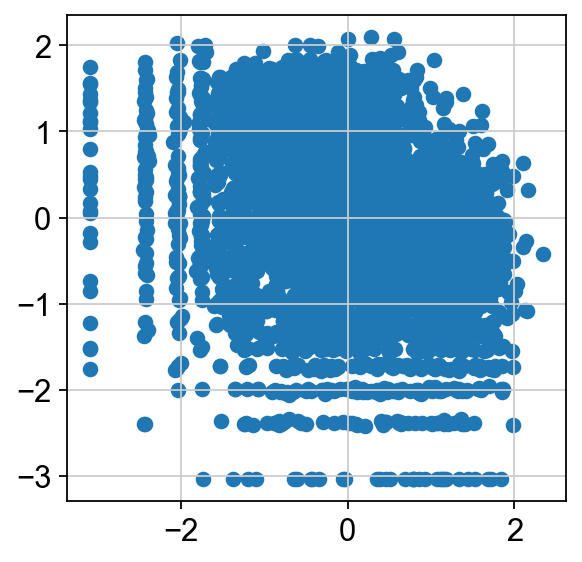

In [15]:
plt.scatter(adata[:, 'PreX0'].X, adata[:, 'PreY1'].X)

computing PCA
    with n_comps=50
    finished (0:00:00)


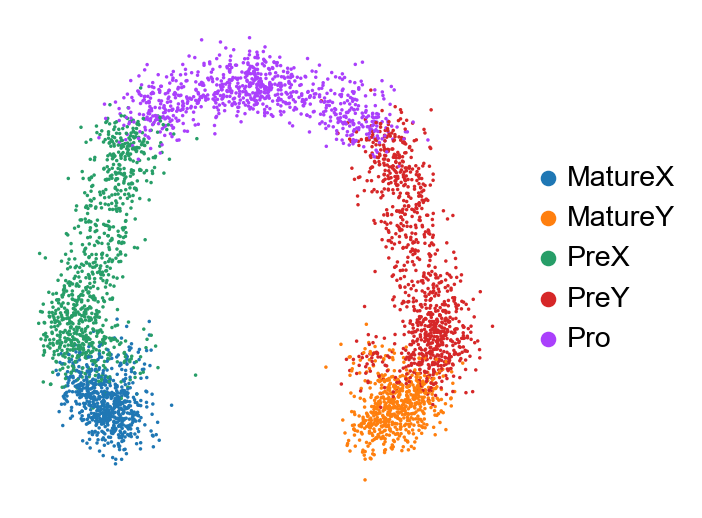

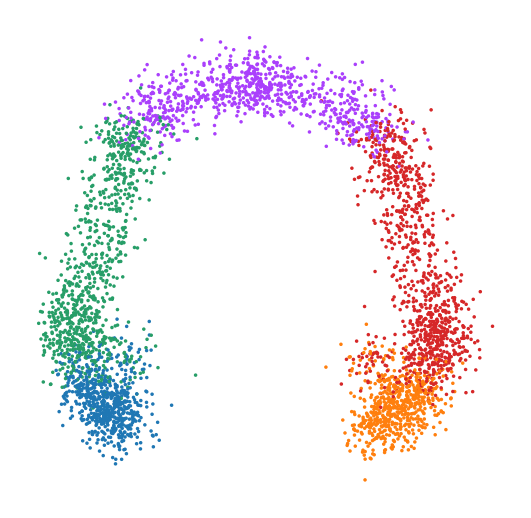

In [118]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color="label", size=10., frameon=False, title="")
sc.pl.pca(adata, color="label", size=10., frameon=False, legend_loc="", title="")

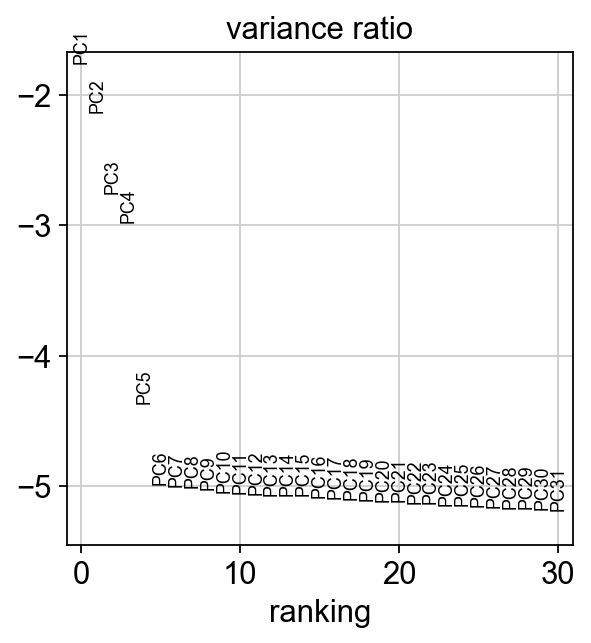

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 3
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


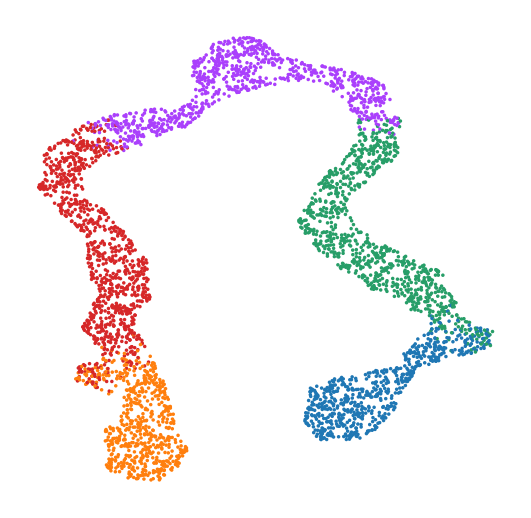

In [126]:
sc.pp.neighbors(adata, n_pcs=3)
sc.tl.umap(adata)
adata.obsm['X_umap'][:, 0] = -adata.obsm['X_umap'][:, 0]
adata.obsm['X_umap'][:, 1] = -adata.obsm['X_umap'][:, 1]
sc.pl.umap(adata, color=['label'], legend_loc=None, size=10., frameon=False, title="")

In [87]:
import sys
sys.path.insert(0,'../marker-selection/')
import scmer

#4000: 62
model = scmer.UmapL1(w=1., lasso=.79e-2, ridge=0., n_pcs=5, perplexity=100., use_beta_in_Q=True, 
                     n_threads=6, max_outer_iter=1)
model.fit(adata.X)
adata.var_names[model.w > 0.]

Calculating distance matrix and scaling factors...
Computing pairwise distances...
Using 6 threads...
Mean value of sigma: 0.514251
Done. Elapsed time: 15.72 seconds. Total: 15.72 seconds.
Creating model without batches...
Optimizing using OWLQN (because lasso is nonzero)...
0 loss (before this step): 4.80375337600708 Nonzero (after): 63 Elapsed time: 35.53 seconds. Total: 51.25 seconds.
Final loss: 3.48805570602417 Nonzero: 63 Elapsed time: 0.60 seconds. Total: 51.86 seconds.


Index(['Pro0', 'Pro1', 'Pro2', 'Pro3', 'Pro4', 'Pro5', 'Pro6', 'Pro7', 'Pro8',
       'Pro9', 'Pro10', 'Pro11', 'Pro12', 'Pro13', 'Pro14', 'Pro15', 'Pro16',
       'Pro17', 'Pro18', 'Pro19', 'PreX0', 'PreX2', 'PreX4', 'PreX5', 'PreX6',
       'PreX7', 'PreX9', 'PreX11', 'PreX13', 'PreX14', 'PreX16', 'PreX17',
       'PreX18', 'PreY0', 'PreY1', 'PreY4', 'PreY5', 'PreY6', 'PreY8', 'PreY9',
       'PreY11', 'PreY12', 'PreY13', 'PreY14', 'PreY15', 'PreY17', 'PreY18',
       'PreY19', 'PreX_PreY0', 'PreX_PreY1', 'PreX_PreY2', 'PreX_PreY3',
       'PreX_PreY4', 'MatureX_MatureY0', 'MatureX_MatureY1',
       'MatureX_MatureY2', 'MatureX_MatureY3', 'MatureX_MatureY4',
       'Checkpoint4', 'GradientX2', 'GradientX3', 'GradientX8', 'GradientY5'],
      dtype='object')

In [88]:
adata.var_names[model.get_mask(45)]

Index(['Pro0', 'Pro1', 'Pro2', 'Pro3', 'Pro4', 'Pro5', 'Pro6', 'Pro7', 'Pro8',
       'Pro9', 'Pro10', 'Pro11', 'Pro12', 'Pro13', 'Pro14', 'Pro15', 'Pro16',
       'Pro17', 'Pro18', 'Pro19', 'PreX2', 'PreX5', 'PreX6', 'PreX7', 'PreX11',
       'PreX13', 'PreX14', 'PreY6', 'PreY8', 'PreY15', 'PreY18', 'PreY19',
       'PreX_PreY0', 'PreX_PreY1', 'PreX_PreY2', 'PreX_PreY3', 'PreX_PreY4',
       'MatureX_MatureY0', 'MatureX_MatureY1', 'MatureX_MatureY2',
       'Checkpoint4', 'GradientX2', 'GradientX3', 'GradientX8', 'GradientY5'],
      dtype='object')

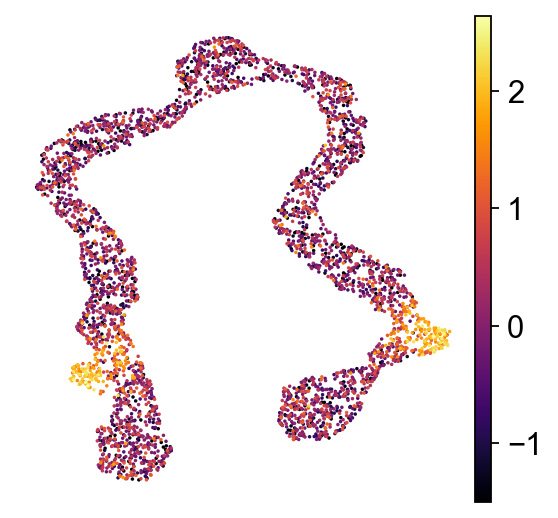

In [129]:
sc.pl.umap(adata, 
           color=['Checkpoint0'],
           ncols=3,
           use_raw=False,
           vmin=-1.5,
           vmax=None,
           legend_loc=None, size=10., color_map='inferno', frameon=False, title="")

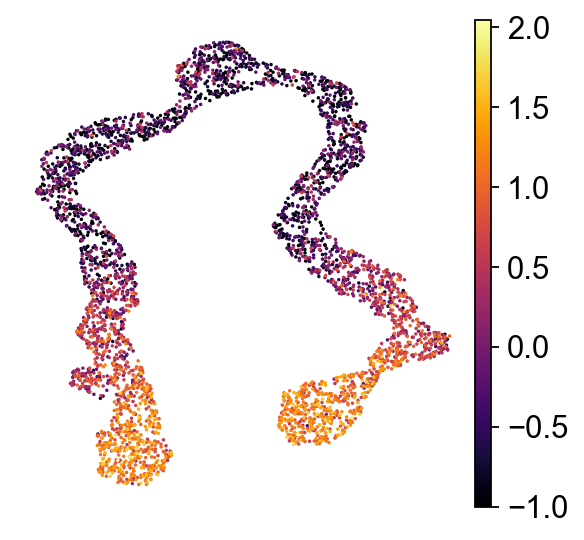

In [136]:
sc.pl.umap(adata, 
           color=['MatureX_MatureY0'],
           ncols=3,
           use_raw=False,
           vmin=-1,
           legend_loc=None, size=10., color_map='inferno', frameon=False, title="")

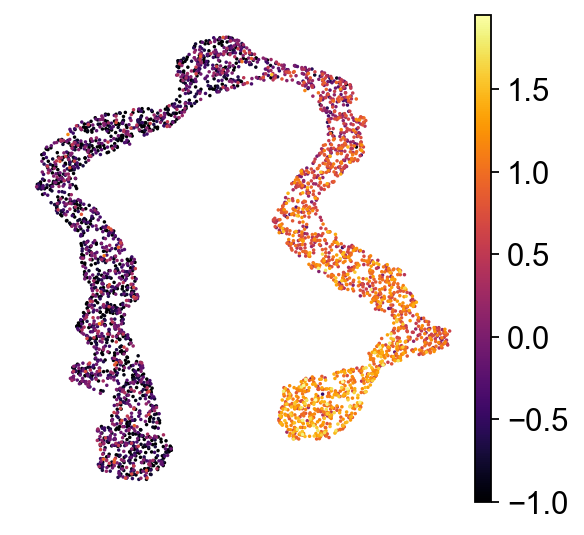

In [134]:
sc.pl.umap(adata, 
           color=['GradientX5'],
           ncols=3,
           use_raw=False,
           vmin=-1,
           legend_loc=None, size=10., color_map='inferno', frameon=False, title="")

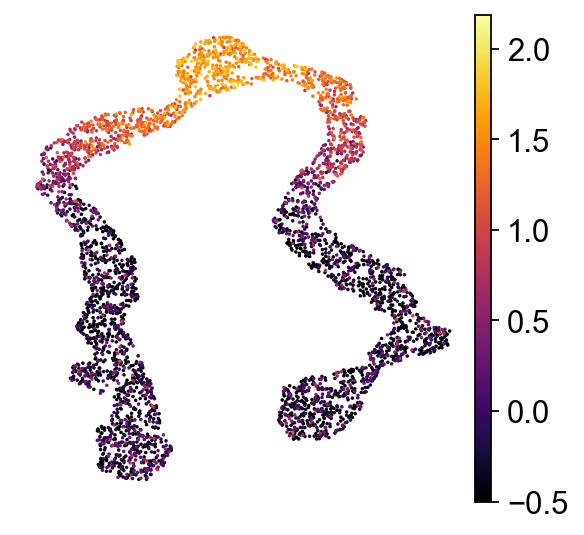

In [135]:
sc.pl.umap(adata, 
           color=['Pro0'],
           ncols=3,
           use_raw=False,
           vmin=-0.5,
           legend_loc=None, size=10., color_map='inferno', frameon=False, title="")

## Metrics 

In [93]:
adata.obs['label_l2'] = adata.obs['label'].astype(str)
mask = np.abs(adata.obs.time - 1.5) * 8. < 0.4
adata.obs['label_l2'][mask] = \
    'checkpoint' + adata.obs['label_l2'][mask].str[-1]

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [94]:
print(adata.obs.label.value_counts() / 4000)
print(adata.obs.label_l2.value_counts() / 4000)

PreY       0.24325
PreX       0.22425
Pro        0.21225
MatureX    0.16725
MatureY    0.15300
Name: label, dtype: float64
PreY           0.22925
PreX           0.21225
Pro            0.21225
MatureX        0.15375
MatureY        0.14025
checkpointY    0.02675
checkpointX    0.02550
Name: label_l2, dtype: float64


### kNN

In [95]:
import sklearn as skl
import scipy as sp
def knn_ri(X, y, n_neighbors=3):
    #y_ = skl.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y).predict(X)
    pdist = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.array(X))) 
    ind = np.argpartition(pdist, n_neighbors, 1)[:, 1:(n_neighbors + 1)] # smallest one is itself, discard
    y_ = [y[ind[i, :]].sum() > n_neighbors / 2 for i in range(ind.shape[0])]
    return "%.2f / %.2f" % (skl.metrics.precision_score(y_true=y, y_pred=y_), skl.metrics.recall_score(y_true=y, y_pred=y_))
    #return y_

In [96]:
from scipy.stats import pearsonr
corr_both = [pearsonr(adata.X[:, i], adata.obs.time.tolist())[0] for i in range(adata.shape[1])]
corr_X = [pearsonr(adata.X[:2000, i], adata.obs.time.tolist()[:2000])[0] for i in range(adata.shape[1])]
corr_Y = [pearsonr(adata.X[2000:, i], adata.obs.time.tolist()[2000:])[0] for i in range(adata.shape[1])]
corr_df = pd.DataFrame(data = {'both': adata.var_names[np.argsort(-np.abs(corr_both))], 
                               'X': adata.var_names[np.argsort(-np.abs(corr_X))], 
                               'Y': adata.var_names[np.argsort(-np.abs(corr_Y))]})

sc.tl.rank_genes_groups(adata, "label", method='wilcoxon')
deg_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])


ranking genes


C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'label_l2' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [97]:
n_features = 50
for i in range(corr_df.shape[0]):
    if len(set(corr_df.iloc[:i, ].values.reshape([-1]))) > n_features:
        break
corr_features = list(set(corr_df.iloc[:i, ].values.reshape([-1])))

for i in range(deg_df.shape[0]):
    if len(set(deg_df.iloc[:i, ].values.reshape([-1]))) > n_features:
        break
deg_features = list(set(deg_df.iloc[:i, ].values.reshape([-1])))

In [98]:
def calc_precision_df(X, y, adata, model, deg_features, corr_features):
    return pd.DataFrame({label_name:
              {'Original': knn_ri(adata.X, label),
               'SCMER': knn_ri(adata.X[:, model.get_mask(n_features)], label),
               'DEG': knn_ri(adata[:, deg_features].X, label),
               'Correlation': knn_ri(adata[:, corr_features].X, label)
              }
             }
            )

In [99]:
label_name = 'checkpointX'
obs_name = 'label_l2'
label = adata.obs[obs_name] == label_name
precision_df = calc_precision_df(X, label, adata, model, deg_features, corr_features)

label_name = 'checkpointY'
obs_name = 'label_l2'
label = adata.obs[obs_name] == label_name
precision_df = precision_df.merge(calc_precision_df(X, label, adata, model, deg_features, corr_features), 
                                  left_index=True, right_index=True)

obs_name = 'label'
for label_name in ['Pro', 'PreX', 'PreY', 'MatureX', 'MatureY']:
    label = adata.obs[obs_name] == label_name
    precision_df = precision_df.merge(calc_precision_df(X, label, adata, model, deg_features, corr_features), 
                                  left_index=True, right_index=True)

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [100]:
precision_df.loc[['SCMER', 'DEG', 'Correlation']]

,checkpointX,checkpointY,Pro,PreX,PreY,MatureX,MatureY
SCMER,0.82 / 0.68,0.87 / 0.67,0.97 / 0.96,0.95 / 0.96,0.94 / 0.94,0.95 / 0.96,0.94 / 0.93
DEG,0.61 / 0.34,0.73 / 0.40,0.94 / 0.95,0.94 / 0.93,0.95 / 0.94,0.94 / 0.95,0.95 / 0.96
Correlation,0.48 / 0.36,0.43 / 0.28,0.91 / 0.96,0.76 / 0.67,0.76 / 0.67,0.88 / 0.95,0.88 / 0.92


In [33]:
corr_features

['MatureX19',
 'MatureX9',
 'Pro7',
 'Pro10',
 'Pro18',
 'MatureY2',
 'Pro1',
 'MatureY16',
 'MatureX5',
 'Pro0',
 'MatureX0',
 'MatureX18',
 'MatureX16',
 'MatureY14',
 'Pro12',
 'MatureY19',
 'MatureX11',
 'MatureX_MatureY4',
 'MatureX12',
 'MatureY4',
 'Pro11',
 'Pro3',
 'MatureY5',
 'Pro2',
 'MatureX_MatureY1',
 'Pro4',
 'MatureX4',
 'Pro9',
 'MatureX8',
 'MatureY8',
 'Pro16',
 'MatureY0',
 'MatureY10',
 'MatureX2',
 'MatureY11',
 'Pro19',
 'Pro5',
 'Pro13',
 'Pro14',
 'Pro17',
 'MatureX_MatureY2',
 'MatureY7',
 'Pro6',
 'Pro15',
 'MatureY13',
 'MatureX_MatureY3',
 'MatureY12',
 'MatureX14',
 'Pro8',
 'MatureY18',
 'MatureX_MatureY0',
 'MatureX17']

In [34]:
deg_features

['PreY7',
 'PreY9',
 'Pro7',
 'MatureX6',
 'PreX0',
 'Pro10',
 'MatureX9',
 'MatureX14',
 'MatureY16',
 'PreX15',
 'MatureX5',
 'PreY5',
 'PreY10',
 'MatureX0',
 'MatureX16',
 'MatureY14',
 'MatureY19',
 'MatureX11',
 'PreX12',
 'PreX10',
 'MatureX7',
 'PreX19',
 'MatureY17',
 'PreY19',
 'Pro11',
 'MatureY5',
 'Pro3',
 'Pro4',
 'MatureY6',
 'PreX16',
 'PreX11',
 'PreX14',
 'MatureY0',
 'MatureY10',
 'MatureX2',
 'PreY1',
 'PreY14',
 'Pro13',
 'Pro5',
 'PreY16',
 'PreX2',
 'Pro14',
 'PreX6',
 'PreX4',
 'Pro6',
 'Pro15',
 'MatureY3',
 'MatureX13',
 'MatureY12',
 'PreY4',
 'Pro12',
 'MatureY18',
 'PreY3',
 'PreY6',
 'MatureX17']

In [35]:
deg_df.style

,MatureX,MatureY,PreX,PreY,Pro
0,MatureX14,MatureY0,PreX0,PreY5,Pro12
1,MatureX17,MatureY16,PreX2,PreY16,Pro10
2,MatureX5,MatureY12,PreX11,PreY9,Pro7
3,MatureX16,MatureY14,PreX19,PreY6,Pro6
4,MatureX6,MatureY10,PreX15,PreY7,Pro14
5,MatureX9,MatureY6,PreX10,PreY1,Pro13
6,MatureX11,MatureY5,PreX16,PreY10,Pro15
7,MatureX0,MatureY19,PreX12,PreY14,Pro4
8,MatureX13,MatureY17,PreX4,PreY19,Pro11
9,MatureX7,MatureY3,PreX14,PreY3,Pro3


In [36]:
len(set(deg_df.iloc[:20, ].values.reshape([-1])))

100

In [37]:
corr_df.style

,both,X,Y
0,Pro12,MatureX2,MatureY5
1,Pro4,MatureX4,MatureY16
2,Pro1,MatureX19,MatureY18
3,MatureX_MatureY3,MatureX5,MatureY14
4,MatureX_MatureY4,MatureX17,MatureY10
5,Pro14,MatureX14,Pro1
6,Pro2,MatureX18,Pro4
7,Pro3,MatureX12,MatureY11
8,MatureX_MatureY0,MatureX16,Pro12
9,Pro5,MatureX11,MatureY2


In [137]:
len(set(corr_df.iloc[:77, ].values.reshape([-1])))

124